Os incêndios florestais são um grave problema para a preservação das Florestas Tropicais. Compreender a frequência dos incêndios florestais em uma série temporal pode ajudar a tomar medidas para evitá-los.

Objetivo: Realizar a previsão de frequências de focos de incêndio para X dias.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from prophet import Prophet
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from tensorflow import keras

import joblib

/home/wolf/anaconda3/envs/ai_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
2025-05-31 22:16:18.101764: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748740578.128726  573679 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748740578.138296  573679 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748740578.167072  573679 computation_placer.cc:177] computation placer already registered. Please c

## Adquirindo os dados

**Download do dataset**

Fonte: [Banco de Dados de Queimadas](https://basedosdados.org/dataset/f06f3cdc-b539-409b-b311-1ff8878fb8d9?raw_data_source=894ea9e3-c94a-4c99-a022-171ce01ac6ff)

In [ ]:
!wget -O dataset_2022.zip https://dataserver-coids.inpe.br/queimadas/queimadas/focos/csv/anual/Brasil_todos_sats/focos_br_todos-sats_2022.zip
!wget -O dataset_2023.zip https://dataserver-coids.inpe.br/queimadas/queimadas/focos/csv/anual/Brasil_todos_sats/focos_br_todos-sats_2023.zip
!wget -O dataset_2024.zip https://dataserver-coids.inpe.br/queimadas/queimadas/focos/csv/anual/Brasil_todos_sats/focos_br_todos-sats_2024.zip

**Descompactando os dados**

Necessário instalar o unzip com:

```bash
    sudo apt-get install zip unzip
```

In [ ]:
!unzip dataset_2022.zip -d dataset/
!unzip dataset_2023.zip -d dataset/
!unzip dataset_2024.zip -d dataset/

## Análise exploratória dos dados

In [4]:
DATA_DIR_2022 = Path('dataset/focos_br_todos-sats_2022.csv')
DATA_DIR_2023 = Path('dataset/focos_br_todos-sats_2023.csv')
DATA_DIR_2024 = Path('dataset/tmp/focos_br_todos-sats_2024.csv')

df_2022 = pd.read_csv(DATA_DIR_2022, parse_dates=['data_pas']) # parse_dates converte o campo de data para um datetime
df_2023 = pd.read_csv(DATA_DIR_2023, parse_dates=['data_pas'])
df_2024 = pd.read_csv(DATA_DIR_2024, parse_dates=['data_pas'])

df = pd.concat([df_2022, df_2023, df_2024], # Junta os dataframes em um só
               ignore_index=True) # Reordena os índices após a concatenação, se necessário

df.head()

,latitude,longitude,data_pas,satelite,pais,estado,municipio,bioma,numero_dias_sem_chuva,precipitacao,risco_fogo,id_area_industrial,frp
0,-11.4152,-56.389099,2022-05-13 01:34:50,METOP-B,Brasil,MATO GROSSO,TABAPORÃ,Amazônia,14.0,5.1,0.1,0,NaN
1,-11.4132,-56.380798,2022-05-13 01:34:50,METOP-B,Brasil,MATO GROSSO,TABAPORÃ,Amazônia,15.0,5.7,0.1,0,NaN
2,-11.4327,-56.375999,2022-05-13 01:34:49,METOP-B,Brasil,MATO GROSSO,TABAPORÃ,Amazônia,15.0,4.9,0.1,0,NaN
3,-11.7623,-56.591202,2022-05-13 01:34:45,METOP-B,Brasil,MATO GROSSO,PORTO DOS GAÚCHOS,Amazônia,20.0,0.9,0.2,0,NaN
4,-11.7720,-56.588902,2022-05-13 01:34:45,METOP-B,Brasil,MATO GROSSO,PORTO DOS GAÚCHOS,Amazônia,20.0,0.9,0.2,0,NaN


Removendo do dataset dados com o campo "numero_dias_sem_chuva" negativos, pois não faz sentido.

In [5]:
df = df.query('numero_dias_sem_chuva >= 0')

In [6]:
df.info(show_counts=True) # Show_counts exibe a quantidade de dados não nulos e tipos das colunas

<class 'pandas.core.frame.DataFrame'>
Index: 17010183 entries, 0 to 17411565
Data columns (total 13 columns):
 #   Column                 Non-Null Count     Dtype         
---  ------                 --------------     -----         
 0   latitude               17010183 non-null  float64       
 1   longitude              17010183 non-null  float64       
 2   data_pas               17010183 non-null  datetime64[ns]
 3   satelite               17010183 non-null  object        
 4   pais                   17010183 non-null  object        
 5   estado                 17010183 non-null  object        
 6   municipio              17010183 non-null  object        
 7   bioma                  17010160 non-null  object        
 8   numero_dias_sem_chuva  17010183 non-null  float64       
 9   precipitacao           17010183 non-null  float64       
 10  risco_fogo             17010183 non-null  float64       
 11  id_area_industrial     17010183 non-null  int64         
 12  frp              

In [7]:
df.describe()

,latitude,longitude,data_pas,numero_dias_sem_chuva,precipitacao,risco_fogo,id_area_industrial,frp
count,1.701018e+07,1.701018e+07,17010183,1.701018e+07,1.701018e+07,1.701018e+07,1.701018e+07,1.587153e+07
mean,-9.664868e+00,-5.280730e+01,2023-11-22 13:49:30.005427456,2.704346e+01,7.415802e-01,-8.728453e+00,1.266830e-01,3.862381e+01
min,-3.341841e+01,-7.386338e+01,2022-01-01 00:03:00,0.000000e+00,0.000000e+00,-9.990000e+02,0.000000e+00,-3.800000e+00
25%,-1.261861e+01,-5.754807e+01,2022-12-01 05:12:00,4.000000e+00,0.000000e+00,5.300000e-01,0.000000e+00,3.800000e+00
50%,-9.030000e+00,-5.261120e+01,2023-11-18 03:46:43,1.000000e+01,0.000000e+00,9.900000e-01,0.000000e+00,1.020000e+01
75%,-6.204385e+00,-4.702992e+01,2024-09-01 17:28:00,3.500000e+01,0.000000e+00,1.000000e+00,0.000000e+00,5.700000e+01
max,5.217610e+00,-3.505485e+01,2024-12-31 23:50:00,3.590000e+02,2.529800e+02,1.000000e+00,3.460000e+02,8.094300e+03
std,5.612614e+00,7.243545e+00,NaN,3.483289e+01,3.709542e+00,9.692822e+01,5.748884e+00,7.126380e+01


In [8]:
# Cria um novo campo apenas com a data, sem a hora
df['data'] = df['data_pas'].dt.date

# Adquire o nome do mês em string
df['mes'] = df['data_pas'].dt.month_name()

# Adquire o nome do mês em número
df['mes_numero'] = df['data_pas'].dt.month

# Adquire o ano
df["ano"] = df["data_pas"].dt.year
df["ano_normalizado"] = df["ano"] - df["ano"].min() # Irá criar uma variável numérica como 1,2,3 dependendo do ano

In [9]:
df_occurrences = df.groupby('data').size().reset_index(name='ocorrencias')
df_occurrences.head()

,data,ocorrencias
0,2022-01-01,1025
1,2022-01-02,1213
2,2022-01-03,1412
3,2022-01-04,1876
4,2022-01-05,1760


### Visualizando a frequência de ocorrências ao longo dos anos (em dias)

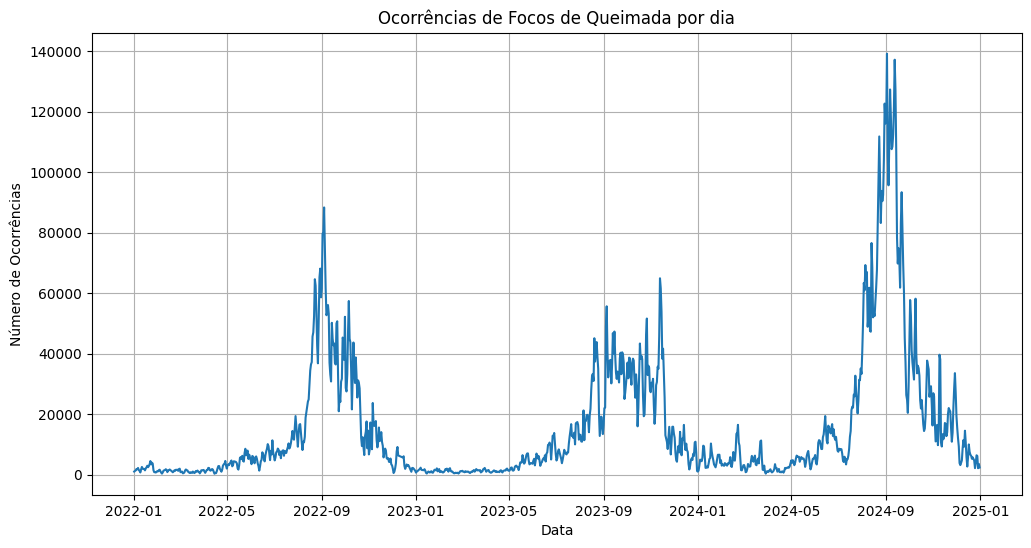

In [10]:
plt.figure(figsize=(12,6))
plt.plot(df_occurrences['data'], df_occurrences['ocorrencias'])
plt.title('Ocorrências de Focos de Queimada por dia')
plt.xlabel('Data')
plt.ylabel('Número de Ocorrências')
plt.grid(True)

### Agrupando dados por bioma, mês e ano

In [11]:
df_occurrences_month = df.groupby(['bioma', 'mes', 'ano_normalizado', 'mes_numero']).agg({ # Agg realiza calculos nas colunas
    'precipitacao': 'mean', # Média da precipitação
    'numero_dias_sem_chuva': lambda x: round(x.mean()), # Média do número de dias sem chuva e arredonda para o número mais próximo
    'pais': 'count' # Utilizando qualquer coluna para fazer a contagem de ocorrências
}).rename(columns={
    'precipitacao': 'media_precipitacao',
    'numero_dias_sem_chuva': 'media_dias_sem_chuva',
    'pais': 'ocorrencias' # Renomeando a coluna "pais" (count) para "ocorrencias"
}).reset_index() # Remove os índices hierárquicos para colunas normais do dataframe

Ordena os dados por ano e mês

In [12]:
df_occurrences_month.sort_values(by=['ano_normalizado', 'mes_numero'], inplace=True)
df_occurrences_month.head()

,bioma,mes,ano_normalizado,mes_numero,media_precipitacao,media_dias_sem_chuva,ocorrencias
12,Amazônia,January,0,1,1.375501,5,19846
48,Caatinga,January,0,1,2.067224,3,5443
84,Cerrado,January,0,1,1.866952,3,14152
120,Mata Atlântica,January,0,1,3.397153,4,15349
156,Pampa,January,0,1,1.171832,7,4601


In [13]:
df_occurrences_month['mes_ano'] = df_occurrences_month['mes_numero'].astype(str) + '_' + df_occurrences_month['ano_normalizado'].astype(str)

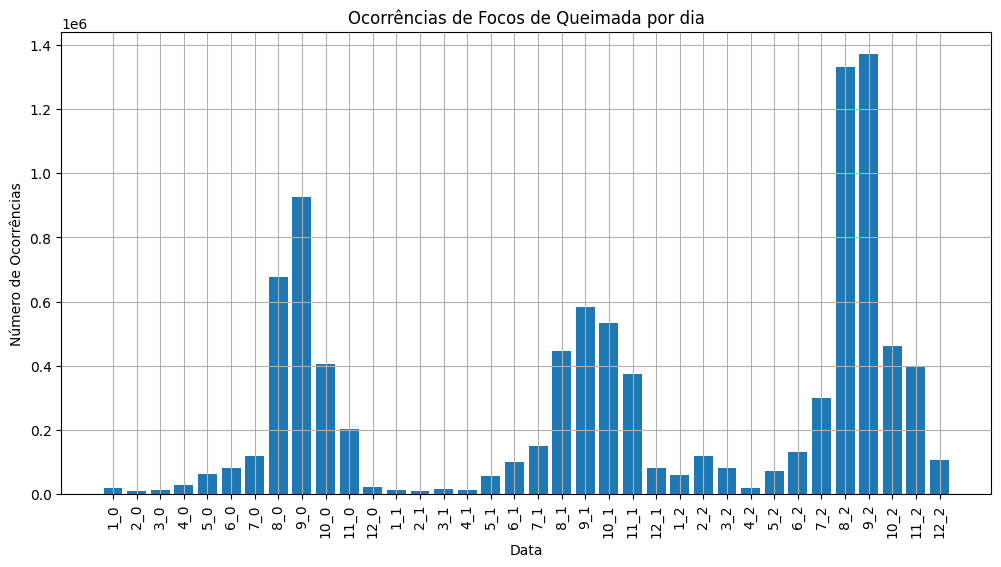

In [14]:
plt.figure(figsize=(12,6))
plt.bar(df_occurrences_month['mes_ano'], df_occurrences_month['ocorrencias'])
plt.title('Ocorrências de Focos de Queimada por dia')
plt.xlabel('Data')
plt.ylabel('Número de Ocorrências')
plt.xticks(rotation=90)
plt.grid(True)

In [15]:
# Dropa a coluna do número do mês, pois não será mais útil após a ordenação e visualização
df_occurrences_month.drop(['mes_numero', 'mes_ano'], axis=1, inplace=True)

In [16]:
dummies = pd.get_dummies(df_occurrences_month, columns=['bioma', 'mes'])
df_occurrences_month_encoded = pd.concat([df_occurrences_month[['bioma', 'mes']], dummies], axis=1)

In [17]:
df_occurrences_month_encoded = df_occurrences_month_encoded.drop(['bioma','mes'], axis=1)
df_occurrences_month_encoded.head()

,ano_normalizado,media_precipitacao,media_dias_sem_chuva,ocorrencias,bioma_Amazônia,bioma_Caatinga,bioma_Cerrado,bioma_Mata Atlântica,bioma_Pampa,bioma_Pantanal,...,mes_December,mes_February,mes_January,mes_July,mes_June,mes_March,mes_May,mes_November,mes_October,mes_September
12,0,1.375501,5,19846,True,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
48,0,2.067224,3,5443,False,True,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
84,0,1.866952,3,14152,False,False,True,False,False,False,...,False,False,True,False,False,False,False,False,False,False
120,0,3.397153,4,15349,False,False,False,True,False,False,...,False,False,True,False,False,False,False,False,False,False
156,0,1.171832,7,4601,False,False,False,False,True,False,...,False,False,True,False,False,False,False,False,False,False


In [18]:
df_occurrences_month_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 216 entries, 12 to 188
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ano_normalizado       216 non-null    int32  
 1   media_precipitacao    216 non-null    float64
 2   media_dias_sem_chuva  216 non-null    int64  
 3   ocorrencias           216 non-null    int64  
 4   bioma_Amazônia        216 non-null    bool   
 5   bioma_Caatinga        216 non-null    bool   
 6   bioma_Cerrado         216 non-null    bool   
 7   bioma_Mata Atlântica  216 non-null    bool   
 8   bioma_Pampa           216 non-null    bool   
 9   bioma_Pantanal        216 non-null    bool   
 10  mes_April             216 non-null    bool   
 11  mes_August            216 non-null    bool   
 12  mes_December          216 non-null    bool   
 13  mes_February          216 non-null    bool   
 14  mes_January           216 non-null    bool   
 15  mes_July              216 n

In [19]:
df_occurrences_month_encoded.describe()

,ano_normalizado,media_precipitacao,media_dias_sem_chuva,ocorrencias
count,216.000000,216.000000,216.000000,2.160000e+02
mean,1.000000,1.230664,13.439815,7.875074e+04
std,0.818393,1.547888,15.774165,1.871717e+05
min,0.000000,0.004737,1.000000,1.060000e+02
25%,0.000000,0.208718,4.000000,3.291000e+03
50%,1.000000,0.742258,6.000000,1.199350e+04
75%,2.000000,1.732737,16.250000,6.355125e+04
max,2.000000,14.706324,81.000000,1.371287e+06


### Analisando a correlação entre as variáveis

In [20]:
corr = df_occurrences_month_encoded.corr(numeric_only=True)

<Axes: >

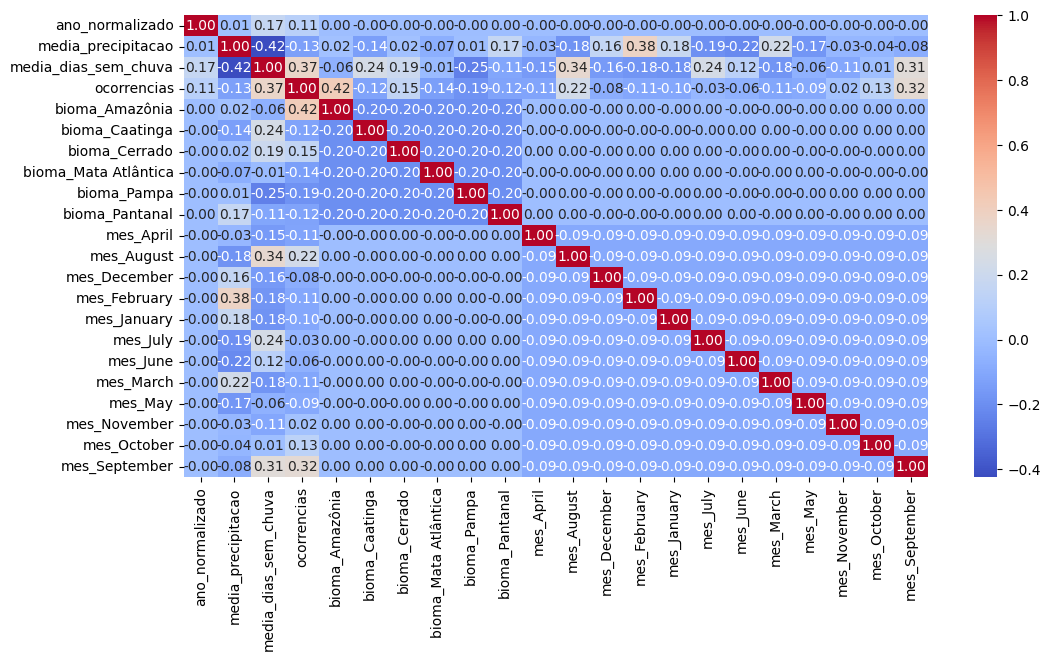

In [21]:
plt.figure(figsize=(12,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')

Há algumas correlações positivas interessantes com a variável alvo (ocorrências), dentre elas:

Mês de **Setembro** (0.32), **Agosto** (0.22) e **Outubro** (0.13), onde ocorrem mais focos de incêndio, ou seja, ocorrência é maior nesses meses.

Assim como, também é possível observar outras correlações positivas além dos meses que influenciam a variável ocorrência ser maior, como a **média dos dias sem chuva** (0.37), pertencer ao bioma **Amazônia** (0.42) ou **Cerrado** (0.15), 

## Pré processando os dados

### Separando em treino e teste

Juntando todos os dados de treino para realizar posteriormente a validação cruzada.

In [22]:
X = df_occurrences_month_encoded.drop('ocorrencias', axis=1)

Aqui usamos os dados sem o tratament one-hot encoding para realizar a estratificação dos dados com as colunas *bioma* e *mes* de forma mais simplificada.

In [23]:
X_no_encoded = df_occurrences_month.drop('ocorrencias', axis=1)
y = df_occurrences_month['ocorrencias']

In [24]:
SEED = 6549

Separando os dados em treino e teste **com aleatorização** (shuffle=true) para floresta regressão linear.

In [25]:
# Necessário test_size ser maior para funcionar a estratificação por mês e bioma
X_train, X_test, y_train, y_test = train_test_split(X_no_encoded, y, test_size=0.33, random_state=SEED, stratify=df_occurrences_month[['mes','bioma']])

### Separando os dados para previsão em redes recorrentes (séries temporais).

Para melhor resultado é necessário pegar os dados de ocorrência **diários** e não mensais.

In [26]:
y_days = df_occurrences.drop('data', axis=1)

Na separação dos dados em treino e teste, precisamos fazer **sem aleatorização** (shuffle=True) para manter a lógica temporal dos dados.

In [27]:
y_train_all_days, y_test_all_days = train_test_split(y_days, test_size=0.2, shuffle=False)

### Visualizando a distribuição dos dados baseado na estratificação de mês e bioma

In [28]:
pd.DataFrame({
    'treino_mes': X_train['mes'].value_counts(),
    'teste_mes': X_test['mes'].value_counts(),
})

,treino_mes,teste_mes
mes,,
April,12,6
August,12,6
December,12,6
February,12,6
January,12,6
July,12,6
June,12,6
March,12,6
May,12,6


In [29]:
pd.DataFrame({
    'treino_bioma': X_train['bioma'].value_counts(),
    'teste_bioma': X_test['bioma'].value_counts(),
})

,treino_bioma,teste_bioma
bioma,,
Amazônia,24,12
Caatinga,24,12
Cerrado,24,12
Mata Atlântica,24,12
Pampa,24,12
Pantanal,24,12


### Realizando o one-hot encoding das variáveis categóricas bioma e mês

É realizado novamente o one-hot encoding pois usamos a tabela de ocorrências por mês (df_occurrences_month) sem o one hot encoding para realizar a estratificação por mês e bioma. Em seguida, precisamos aplicar o one-hot encoding novamente nos dados de treino e teste.

In [30]:
categorical_cols = ['mes', 'bioma']

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Seleciona apenas colunas categoricas do X_train e X_test
X_train_cat = X_train[categorical_cols]
X_test_cat = X_test[categorical_cols]

# Aplica o One Hot Encoding
X_train_cat_encoded = encoder.fit_transform(X_train_cat)
X_test_cat_encoded = encoder.transform(X_test_cat)

In [31]:
# Adquire os nomes das colunas após o one-hot encoding
encoded_col_names = encoder.get_feature_names_out(categorical_cols)

# Transforma em dataframe
X_train_encoded_df = pd.DataFrame(X_train_cat_encoded, columns=encoded_col_names, index=X_train.index)
X_test_encoded_df = pd.DataFrame(X_test_cat_encoded, columns=encoded_col_names, index=X_test.index)

# Resultado, uma tabela com todas as colunas categoricas 
X_train_encoded_df.head()

,mes_April,mes_August,mes_December,mes_February,mes_January,mes_July,mes_June,mes_March,mes_May,mes_November,mes_October,mes_September,bioma_Amazônia,bioma_Caatinga,bioma_Cerrado,bioma_Mata Atlântica,bioma_Pampa,bioma_Pantanal
156,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
207,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
42,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Porém, não podemos esquecer de juntar essas colunas categóricas ao dataset original.

In [32]:
# Junta o dataset com as colunas categóricas transformadas com OneHot Encoding com o dataset completo
df_X_train = pd.concat([X_train_encoded_df, X_train], axis=1)
df_X_test = pd.concat([X_test_encoded_df, X_test], axis=1)

# Remove as colunas categóricas antigas
df_X_train.drop(['mes', 'bioma'], axis=1, inplace=True)
df_X_test.drop(['mes', 'bioma'], axis=1, inplace=True)

df_X_train.head()

,mes_April,mes_August,mes_December,mes_February,mes_January,mes_July,mes_June,mes_March,mes_May,mes_November,...,mes_September,bioma_Amazônia,bioma_Caatinga,bioma_Cerrado,bioma_Mata Atlântica,bioma_Pampa,bioma_Pantanal,ano_normalizado,media_precipitacao,media_dias_sem_chuva
156,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1.171832,7
207,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.514482,6
167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2,0.651551,4
134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2,0.209748,22
42,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.445682,8


In [33]:
df_X_train.shape, y_train.shape

((144, 21), (144,))

In [34]:
df_X_test.shape, y_test.shape

((72, 21), (72,))

### Padronização dos dados com StandardScaler

In [35]:
scaler = StandardScaler()

df_X_train_scaled = scaler.fit_transform(df_X_train)
df_X_test_scaled = scaler.transform(df_X_test)

# Exporta scaler para ser usado posteriormente
joblib.dump(scaler, 'scaler.joblib')

['scaler.joblib']

In [36]:
scaler_time_series = StandardScaler()

X_train_no_shuffle_scaled = scaler_time_series.fit_transform(y_train_all_days)
X_test_no_shuffle_scaled = scaler_time_series.transform(y_test_all_days)

### Preparação dos dados de séries temporais

In [37]:
# Criando uma função para realizar a preparação de séries temporais de forma manual
def window_view(array, n_length):
    X, y = [], []

    # O loop começara com n_length
    for i in range(n_length, len(array)):

        # Faz uma subtração com a iteração atual e a quantidade de passos
        X.append(array[i-n_length:i]) # Janela de entrada
        y.append(array[i]) # Valor de saída 

    return np.array(X), np.array(y)

In [38]:
WINDOW_LENGHT = 50

In [39]:
X_train_ts, y_train_ts = window_view(X_train_no_shuffle_scaled, WINDOW_LENGHT)
X_test_ts, y_test_ts = window_view(X_test_no_shuffle_scaled, WINDOW_LENGHT)

In [40]:
X_train_ts.shape, y_train_ts.shape

((813, 50, 1), (813, 1))

In [41]:
X_test_ts.shape, y_test_ts.shape

((166, 50, 1), (166, 1))

## Testando modelos para prever a quantidade de ocorrências do mês

Posteriormente, iremos converter o resultado da predição do modelo (quantidade de ocorrências por mês) em um valor percentual que significará a probabilidade de ocorrer incêndios naquele mês específico.

Quanto maior as ocorrências naquele mês e baseado nas características de dias sem chuva, precipitação e bioma, maior será esse percentual.

In [42]:
def view_scores(y_true, y_pred, title):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(title)
    print(f'MSE: {mse}')
    print(f'RMSE: {np.sqrt(mse)}')
    print(f'R² Score: {r2*100:.2f}')

In [43]:
def cros_validate_view_scores(results):
   mse_scores = -results['test_neg_mean_squared_error'].mean() # Realiza a média e converte para valores positivos
   r2_scores = results['test_r2'].mean() # Realiza a média e converte para valores positivos
   
   print(f'MSE: {mse_scores}')
   print(f'RMSE: {np.sqrt(mse_scores)}')
   print(f'R²: {r2_scores}')

In [44]:
kfold = KFold(n_splits=10, shuffle=True, random_state=SEED)

### Floresta Aleatória

Padronização / escalonamento desnecessário para Floresta Aleatória.

In [45]:
model_rf = RandomForestRegressor(random_state=SEED)
model_rf.fit(df_X_train, y_train)

model_rf_predict = model_rf.predict(df_X_test)
view_scores(y_test, model_rf_predict, 'Floresta Aleatória')

Floresta Aleatória
MSE: 11295848326.463448
RMSE: 106281.92850368988
R² Score: 68.17


#### Validação cruzada

In [46]:
pipeline_rf = Pipeline([
    ('estimator', RandomForestRegressor(random_state=SEED))
])

results_rf = cross_validate(pipeline_rf, X, y,
                            cv=kfold,
                            scoring=['neg_mean_squared_error', 'r2'])
cros_validate_view_scores(results_rf)

MSE: 9094064064.000746
RMSE: 95362.80230782203
R²: 0.6649627786577006


### Redes Neurais

In [47]:
model_keras = keras.Sequential([
    keras.layers.Dense(256, activation='relu', input_shape=(df_X_train.shape[1],)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='linear')
])

/home/wolf/anaconda3/envs/ai_env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1748740627.820423  573679 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6102 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5


In [48]:
model_keras.compile(optimizer=keras.optimizers.Adam(),
                    loss=keras.losses.MeanSquaredError(),
                    metrics=[keras.metrics.R2Score(), keras.metrics.RootMeanSquaredError()])

model_keras.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         5,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,409 (193.00 KB)

 Trainable params: 49,409 (193.00 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:
callbacks_NN = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
             keras.callbacks.ModelCheckpoint(monitor='val_loss',
                                             filepath='regression_best_model.keras', save_best_only=True)]

In [50]:
history = model_keras.fit(df_X_train_scaled, y_train,
                epochs=400,
                batch_size=8,
                validation_data=(df_X_test_scaled, y_test),
                callbacks=callbacks_NN)

Epoch 1/400


I0000 00:00:1748740630.062742  573932 service.cc:152] XLA service 0x7f61600051a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748740630.062780  573932 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 2060 SUPER, Compute Capability 7.5
2025-05-31 22:17:10.094157: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1748740630.306471  573932 cuda_dnn.cc:529] Loaded cuDNN version 90501


17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 45001265152.0000 - r2_score: -0.2065 - root_mean_squared_error: 206451.8906

I0000 00:00:1748740631.277866  573932 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 44582748160.0000 - r2_score: -0.2045 - root_mean_squared_error: 206040.8594 - val_loss: 41166610432.0000 - val_r2_score: -0.1599 - val_root_mean_squared_error: 202895.5625
Epoch 2/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 50757324800.0000 - r2_score: -0.2404 - root_mean_squared_error: 221472.8438 - val_loss: 41163440128.0000 - val_r2_score: -0.1598 - val_root_mean_squared_error: 202887.7500
Epoch 3/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 60116119552.0000 - r2_score: -0.1891 - root_mean_squared_error: 240719.5156 - val_loss: 41146298368.0000 - val_r2_score: -0.1593 - val_root_mean_squared_error: 202845.5000
Epoch 4/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 66577158144.0000 - r2_score: -0.1713 - root_mean_squared_error: 246233.9844 - val_loss: 41075142656.0000 - val_r2_score: -0.1573 - val_root_mean_squared_error: 202670.0312
Epoch 5/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 27417491456.0000 - r2_scor

In [51]:
def view_history(model_history):
    # Perda -> Quanto menor, melhor
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.title("R² por época")
    plt.plot(model_history.history['r2_score'])
    plt.plot(model_history.history['val_r2_score'])
    plt.legend(['Treino', 'Validação'])
    plt.xlabel("Época")
    plt.ylabel("R²")
    
    # R² Score -> Quanto maior, melhor
    plt.subplot(1,2,2)
    plt.title("Perda por época")
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.legend(['Treino', 'Validação'])
    plt.xlabel("Época")
    plt.ylabel("Perda")

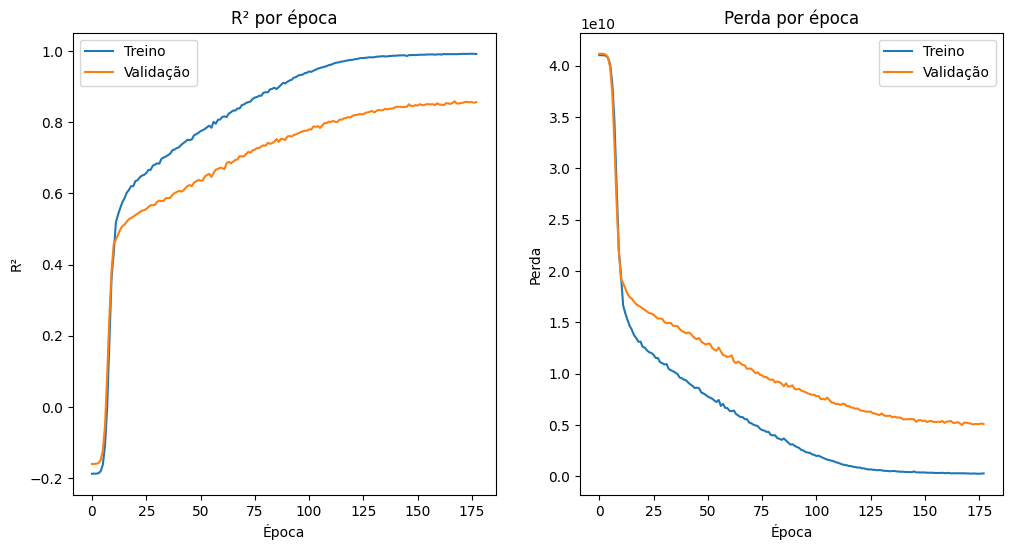

In [52]:
view_history(history)

In [53]:
predict_keras_train = model_keras.predict(df_X_train_scaled)
predict_keras_test = model_keras.predict(df_X_test_scaled)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


In [54]:
predict_keras_test = predict_keras_test.reshape(-1)

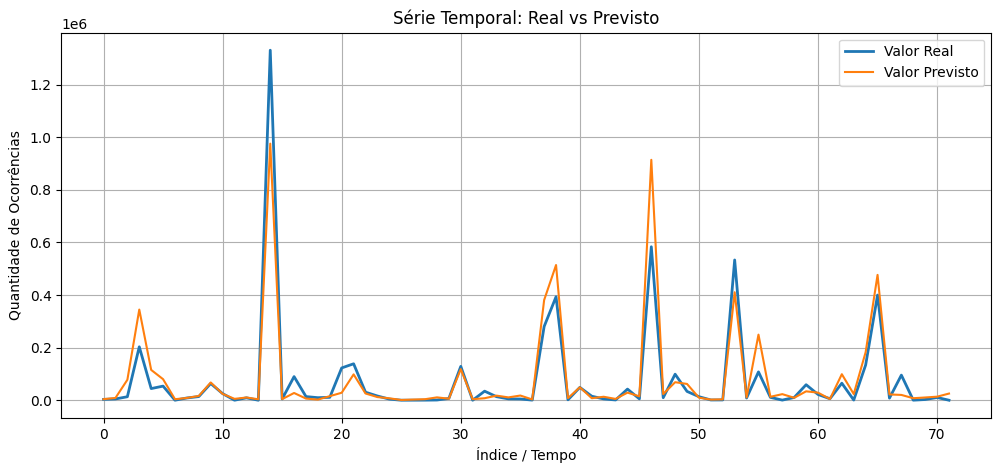

In [55]:
plt.figure(figsize=(12, 5))
plt.plot(np.array(y_test), label='Valor Real', linewidth=2)
plt.plot(predict_keras_test, label='Valor Previsto')
plt.legend()
plt.title('Série Temporal: Real vs Previsto')
plt.xlabel('Índice / Tempo')
plt.ylabel('Quantidade de Ocorrências')
plt.grid(True)

### Criando constantes para gerar o **índice de risco percentual**

Iremos criar uma **tabela de referência** que contém as **estatísticas históricas esperadas** (média e desvio padrão) de focos por bioma e mês. Iremos usar essas estatísticas como **base de comparação** para calcular o **risco percentual** da predição.

Não é uma técnica perfeita, mas desta forma é possível retornar um valor mais compreensível para o usuário que diz respeito sobre o **risco de fogo** em um **bioma** em determinado **mês** do ano, baseado também na quantidade de **dias sem chuva** e **níveis de precipitação** atuais.

In [56]:
df_occurrences_month.head()

,bioma,mes,ano_normalizado,media_precipitacao,media_dias_sem_chuva,ocorrencias
12,Amazônia,January,0,1.375501,5,19846
48,Caatinga,January,0,2.067224,3,5443
84,Cerrado,January,0,1.866952,3,14152
120,Mata Atlântica,January,0,3.397153,4,15349
156,Pampa,January,0,1.171832,7,4601


In [57]:
ref_stats = df_occurrences_month.groupby(['bioma', 'mes'])['ocorrencias'].agg(['mean', 'std']).reset_index()
ref_stats.head()

,bioma,mes,mean,std
0,Amazônia,April,14629.000000,3945.555981
1,Amazônia,August,818004.666667,458266.716650
2,Amazônia,December,70956.000000,43632.290944
3,Amazônia,February,45173.000000,64228.733881
4,Amazônia,January,31513.333333,25449.777294


Remove acentuações das palavras no csv, para facilitar a busca, posteriormente.

In [58]:
import unicodedata

def remove_accents(input_str: str) -> str:
    return ''.join(c for c in unicodedata.normalize('NFD', input_str) if unicodedata.category(c) != 'Mn')

In [59]:
for col in ref_stats.select_dtypes(include=['object', 'string']).columns:
    ref_stats[col] = ref_stats[col].str.replace(' ', '').apply(remove_accents)

In [60]:
ref_stats.to_csv('referencia_estatistica_bioma_mes.csv', index=False)

In [61]:
risks = []
months = []
biomas = []
rains = []

# Necessário zip() para emparelhar corretamente os valores de mês e bioma
for idx, (mes, bioma, chuva, pred) in enumerate(zip(X_test['mes'], X_test['bioma'], X_test['media_dias_sem_chuva'], predict_keras_test)):
    mes = remove_accents(mes.replace(' ', ''))
    bioma = remove_accents(bioma.replace(' ', ''))
    
    # Adquire o limite baseado no mês e bioma
    stats = ref_stats[(ref_stats['mes'] == mes) & (ref_stats['bioma'] == bioma)].iloc[0]
    
    risk = (pred - stats['mean']) / stats['std']
    
    risk_percent = min(max((risk * 10) + 50, 1), 100) # centraliza 0 no 50%, evita <0 ou >100
    
    risks.append(risk_percent)
    months.append(mes)
    biomas.append(bioma)
    rains.append(chuva)

In [62]:
df_risks = pd.DataFrame({
    'predições': predict_keras_test,
    'bioma': biomas,
    'mes': months,
    'media_dias_sem_chuva': rains,
    'riscos (%)': risks
})
df_risks.head()

,predições,bioma,mes,media_dias_sem_chuva,riscos (%)
0,4102.417969,Caatinga,April,10,64.436785
1,8748.757812,MataAtlantica,January,4,46.848431
2,77764.234375,Pantanal,November,3,49.907155
3,344670.250000,Cerrado,August,57,50.285749
4,115275.906250,Amazonia,May,13,100.000000


### Exemplo de como deverá ser enviado os dados para predição

In [63]:
df_X_train.head()

,mes_April,mes_August,mes_December,mes_February,mes_January,mes_July,mes_June,mes_March,mes_May,mes_November,...,mes_September,bioma_Amazônia,bioma_Caatinga,bioma_Cerrado,bioma_Mata Atlântica,bioma_Pampa,bioma_Pantanal,ano_normalizado,media_precipitacao,media_dias_sem_chuva
156,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1.171832,7
207,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.514482,6
167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2,0.651551,4
134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2,0.209748,22
42,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.445682,8


In [64]:
df_X_train.columns

Index(['mes_April', 'mes_August', 'mes_December', 'mes_February',
       'mes_January', 'mes_July', 'mes_June', 'mes_March', 'mes_May',
       'mes_November', 'mes_October', 'mes_September', 'bioma_Amazônia',
       'bioma_Caatinga', 'bioma_Cerrado', 'bioma_Mata Atlântica',
       'bioma_Pampa', 'bioma_Pantanal', 'ano_normalizado',
       'media_precipitacao', 'media_dias_sem_chuva'],
      dtype='object')

### Redes Neurais Recorrentes (LSTM)

In [65]:
model = keras.Sequential([
    keras.layers.LSTM(units=50,
         return_sequences=True, # Garante que a camada LSTM retorne uma sequência completa (shape (batch_size, timesteps, units))
         input_shape=(X_train_ts.shape[1], X_train_ts.shape[2])), # Define como qtd de passos e qtd de features
    keras.layers.Dropout(0.2),
    
    keras.layers.LSTM(units=50,
         return_sequences=True),
    keras.layers.Dropout(0.2),
    
    keras.layers.LSTM(units=50,
         return_sequences=True),
    keras.layers.Dropout(0.2),
    
    keras.layers.LSTM(units=50),
    keras.layers.Dropout(0.2),
    
    keras.layers.Dense(units=1) # Caso não for especificado a função de ativação, será "linear"
])

/home/wolf/anaconda3/envs/ai_env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [66]:
model.compile(loss=keras.losses.MeanSquaredError(),
              optimizer=keras.optimizers.RMSprop(learning_rate=0.0001),
              metrics=[keras.metrics.R2Score()])

model_keras.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         5,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,229 (579.02 KB)

 Trainable params: 49,409 (193.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 98,820 (386.02 KB)

In [67]:
callbacks_RNN = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
             keras.callbacks.ModelCheckpoint(monitor='val_loss',
                             filepath='best_model_recurrent_LSTM.keras',
                             save_best_only=True),
             keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)]

In [68]:
history = model.fit(X_train_ts, y_train_ts,
                    batch_size=16,
                    validation_data=(X_test_ts, y_test_ts),
                    callbacks=callbacks_RNN,
                    epochs=200)

Epoch 1/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 0.9875 - r2_score: 0.0928 - val_loss: 6.5054 - val_r2_score: -0.1396 - learning_rate: 1.0000e-04
Epoch 2/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 17s 339ms/step - loss: 0.4971 - r2_score: 0.5303 - val_loss: 5.2867 - val_r2_score: 0.0739 - learning_rate: 1.0000e-04
Epoch 3/200
51/51 ━━━━━━━━━━━━━━━━━━━━ -13s 34ms/step - loss: 0.3260 - r2_score: 0.6517 - val_loss: 4.9046 - val_r2_score: 0.1408 - learning_rate: 1.0000e-04
Epoch 4/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.2953 - r2_score: 0.7083 - val_loss: 4.5246 - val_r2_score: 0.2074 - learning_rate: 1.0000e-04
Epoch 5/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.2532 - r2_score: 0.7493 - val_loss: 3.9365 - val_r2_score: 0.3104 - learning_rate: 1.0000e-04
Epoch 6/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.2369 - r2_score: 0.7337 - val_loss: 4.1316 - val_r2_score: 0.2762 - learning_rate: 1.0000e-04
Epoch 7/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss:

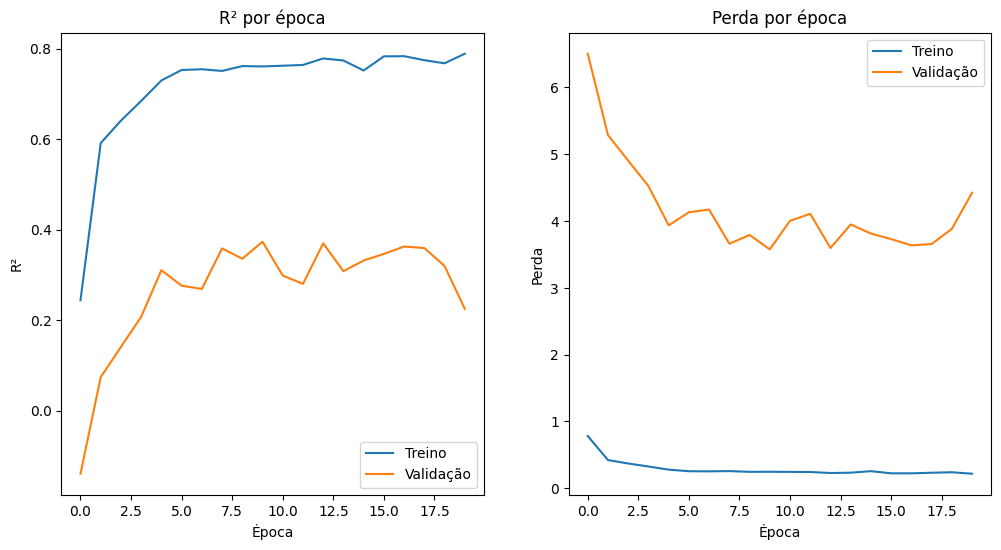

In [69]:
view_history(history)

In [70]:
y_test_predicts = model.predict(X_test_ts)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


In [71]:
y_test_ts = scaler_time_series.inverse_transform(y_test_ts)
y_test_predicts = scaler_time_series.inverse_transform(y_test_predicts)

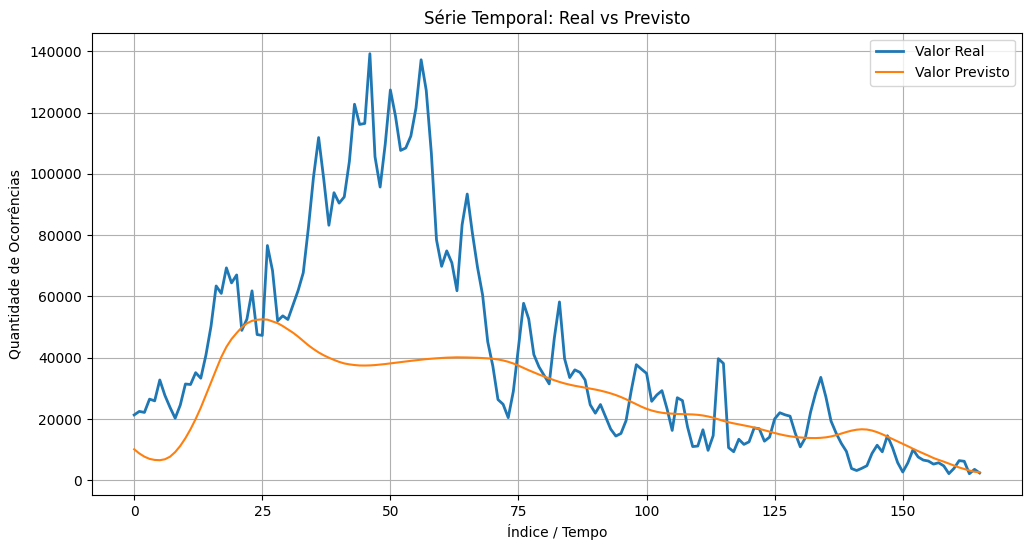

In [72]:
plt.figure(figsize=(12, 6))
plt.plot(np.array(y_test_ts), label='Valor Real', linewidth=2)
plt.plot(y_test_predicts.reshape(-1), label='Valor Previsto')
plt.legend()
plt.title('Série Temporal: Real vs Previsto')
plt.xlabel('Índice / Tempo')
plt.ylabel('Quantidade de Ocorrências')
plt.grid(True)

Este modelo com LSTM nos dados de teste não conseguiu prever a sazonalidade da frequência de incêndios.

### Prophet

In [73]:
df_occurrences_train, df_occurrences_test = train_test_split(df_occurrences, test_size=0.2, shuffle=False)

In [74]:
df_occurrences_train.columns = ['ds', 'y']
df_occurrences_train['ds'] = pd.to_datetime(df_occurrences_train['ds'])

df_occurrences_test.columns = ['ds', 'y']
df_occurrences_test['ds'] = pd.to_datetime(df_occurrences_test['ds'])

In [75]:
df_occurrences_train.head()

,ds,y
0,2022-01-01,1025
1,2022-01-02,1213
2,2022-01-03,1412
3,2022-01-04,1876
4,2022-01-05,1760


In [76]:
model_prophet = Prophet()

model_prophet.fit(df_occurrences_train)

22:18:27 - cmdstanpy - INFO - Chain [1] start processing
22:18:27 - cmdstanpy - INFO - Chain [1] done processing


In [77]:
periods_for_predict = len(df_occurrences) - len(df_occurrences_train)
periods_for_predict

216

In [78]:
future = model_prophet.make_future_dataframe(periods=periods_for_predict)
predict_phophet = model_prophet.predict(future)

In [79]:
predict_prophet_test = predict_phophet.tail(periods_for_predict)

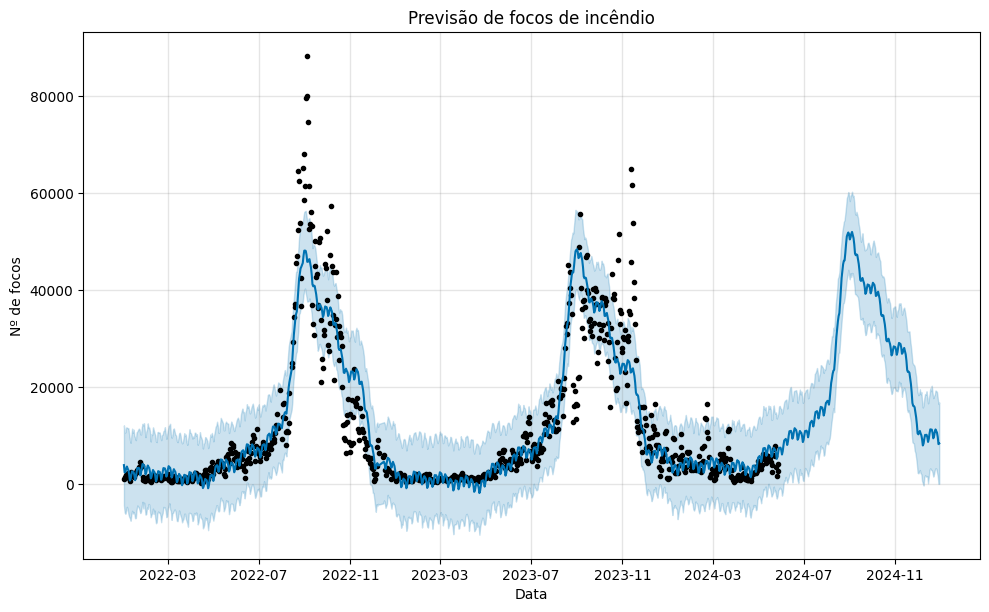

In [80]:
model_prophet.plot(predict_phophet)
plt.title("Previsão de focos de incêndio")
plt.xlabel("Data")
plt.ylabel("Nº de focos")
plt.grid(True)
plt.show()

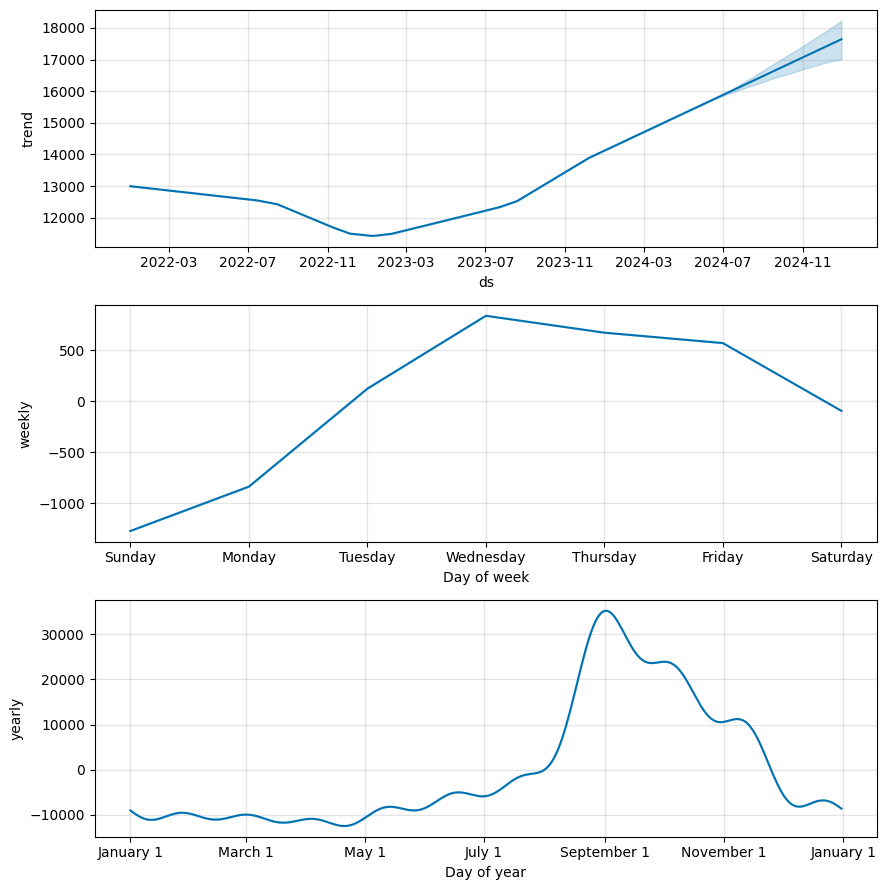

In [81]:
model_prophet.plot_components(predict_phophet)
plt.show()

### Visualizando dados reais x previsão do Prophet

In [82]:
df_occurrences_test = df_occurrences_test.reset_index(drop=True)
predict_prophet_test = predict_prophet_test.reset_index(drop=True)

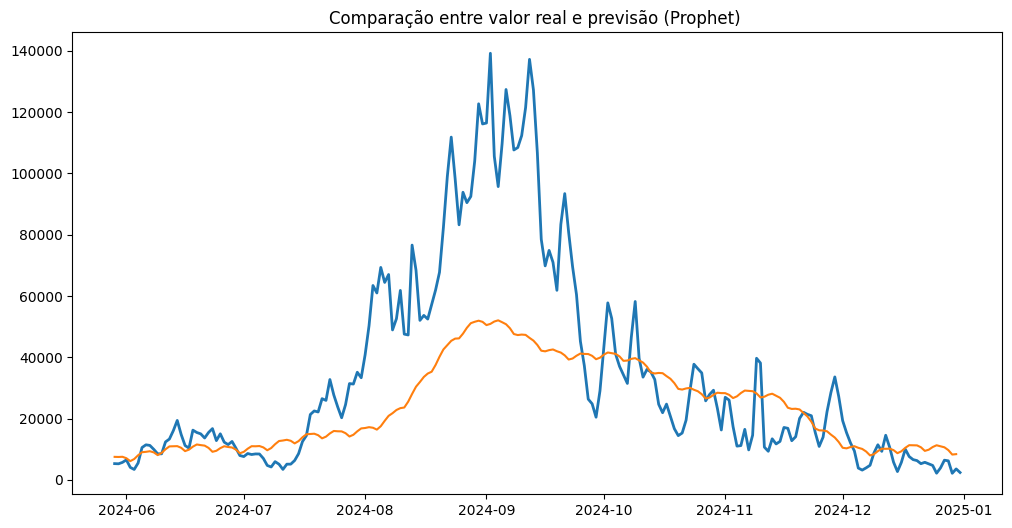

In [83]:
plt.figure(figsize=(12,6))
plt.title("Comparação entre valor real e previsão (Prophet) ")
plt.plot(df_occurrences_test['ds'], df_occurrences_test['y'], label='Real', linewidth=2)
plt.plot(predict_prophet_test['ds'], predict_prophet_test['yhat'], label='Previsão (Prophet)')

Infelizmente, assim como no modelo com LSTM o resultado dos testes com o Prophet não foram promissores, pois nos dados de teste o modelo não conseguiu prever muito bem a sazonalidade dos incêndios florestais.

## Conclusão

Decidimos utilizar o modelo de Regressão com Redes Neurais, pois dentre todos os modelos que testamos, foi um dos modelos que apresentou resultados plaúsiveis. Onde o objetivo seria retornar um valor de **risco de fogo percentual** que poderia ocorrer em um **bioma** em determinado **mês** do ano, baseado também na quantidade de **dias sem chuva** e **níveis de precipitação** atuais.